# Нейрон с различными функциями активации

В этом задании нужно будет: 
- самостоятельно реализовать класс **`Neuron()`** с различными функциями активации (ReLU, LeakyReLU и ELU)

- обучить и протестировать этот класс на сгенерированных и реальных данных

**Достаточно реализовать ReLU и ещё одну из двух.**

In [1]:
import numpy as np
import pandas as pd
import warnings

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

В данном случае мы снова решаем задачу бинарной классификации (2 класса: 1 или 0). Мы уже выяснили (в ноутбуке про `logloss`), что плохо брать для классификации квадратичную функцию потерь, однако здесь для простоты возьмём её:

$$
Loss(\hat{y}, y) = \frac{1}{n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2
$$  

Здесь $w \cdot X_i$ - скалярное произведение, а $\hat{y_i} = \sigma(w \cdot X_i) =\frac{1}{1+e^{-w \cdot X_i}} $ - сигмоида ($i$ -- номер объекта в выборке). 

In [3]:
def loss(y_pred, y):
    y_pred = y_pred.reshape(-1, 1)
    y = np.array(y).reshape(-1, 1)
    return 0.5 * np.mean((y_pred - y) ** 2)

Далее будут предложены несколько функций активации, и Вам нужно реализовать класс `Neuron` по аналогии с тем, как это было на семинаре. Сам принцип тот же, но меняются формула обновления весов и формула предсказания.

## Загрузка данных для тестирования

In [4]:
!gdown 1hpO1lqvbdZ6K5zO66erNcYMr2rv_EFF1
!gdown 1_1YvZgUAgjKuRKPkkVnJlzQJy7rgkqBR

Downloading...
From: https://drive.google.com/uc?id=1hpO1lqvbdZ6K5zO66erNcYMr2rv_EFF1
To: /content/apples_pears.csv
100% 43.6k/43.6k [00:00<00:00, 47.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_1YvZgUAgjKuRKPkkVnJlzQJy7rgkqBR
To: /content/voice.csv
100% 1.07M/1.07M [00:00<00:00, 125MB/s]


In [5]:
apples_pears = pd.read_csv("apples_pears.csv")
apples_pears

,yellowness,symmetry,target
0,0.779427,0.257305,1.0
1,0.777005,0.015915,1.0
2,0.977092,0.304210,1.0
3,0.043032,0.140899,0.0
4,0.760433,0.193123,1.0
...,...,...,...
995,0.288482,0.051186,0.0
996,0.892424,0.795257,0.0
997,0.927219,0.134986,1.0
998,0.015830,0.481322,0.0


In [6]:
voice = pd.read_csv("voice.csv")
voice

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3163,0.131884,0.084734,0.153707,0.049285,0.201144,0.151859,1.762129,6.630383,0.962934,0.763182,...,0.131884,0.182790,0.083770,0.262295,0.832899,0.007812,4.210938,4.203125,0.161929,female
3164,0.116221,0.089221,0.076758,0.042718,0.204911,0.162193,0.693730,2.503954,0.960716,0.709570,...,0.116221,0.188980,0.034409,0.275862,0.909856,0.039062,3.679688,3.640625,0.277897,female
3165,0.142056,0.095798,0.183731,0.033424,0.224360,0.190936,1.876502,6.604509,0.946854,0.654196,...,0.142056,0.209918,0.039506,0.275862,0.494271,0.007812,2.937500,2.929688,0.194759,female
3166,0.143659,0.090628,0.184976,0.043508,0.219943,0.176435,1.591065,5.388298,0.950436,0.675470,...,0.143659,0.172375,0.034483,0.250000,0.791360,0.007812,3.593750,3.585938,0.311002,female


In [7]:
voice.replace({"label": {"female": 0, "male": 1}}, inplace=True)
voice

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,1
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,1
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,1
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,1
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3163,0.131884,0.084734,0.153707,0.049285,0.201144,0.151859,1.762129,6.630383,0.962934,0.763182,...,0.131884,0.182790,0.083770,0.262295,0.832899,0.007812,4.210938,4.203125,0.161929,0
3164,0.116221,0.089221,0.076758,0.042718,0.204911,0.162193,0.693730,2.503954,0.960716,0.709570,...,0.116221,0.188980,0.034409,0.275862,0.909856,0.039062,3.679688,3.640625,0.277897,0
3165,0.142056,0.095798,0.183731,0.033424,0.224360,0.190936,1.876502,6.604509,0.946854,0.654196,...,0.142056,0.209918,0.039506,0.275862,0.494271,0.007812,2.937500,2.929688,0.194759,0
3166,0.143659,0.090628,0.184976,0.043508,0.219943,0.176435,1.591065,5.388298,0.950436,0.675470,...,0.143659,0.172375,0.034483,0.250000,0.791360,0.007812,3.593750,3.585938,0.311002,0


In [8]:
scaler = MinMaxScaler()

voice[voice.columns] = scaler.fit_transform(voice[voice.columns])
voice

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.096419,0.473409,0.084125,0.060063,0.204956,0.254828,0.367853,0.208279,0.635798,0.564526,...,0.096419,0.157706,0.030501,0.981526,0.000000,0.006452,0.000000,0.000000,0.000000,1.0
1,0.125828,0.505075,0.116900,0.077635,0.215683,0.246961,0.644279,0.483766,0.630964,0.591578,...,0.125828,0.287642,0.031140,0.834600,0.000407,0.006452,0.002144,0.002146,0.056449,1.0
2,0.179222,0.675536,0.102873,0.034284,0.385912,0.457148,0.885255,0.782275,0.442738,0.548382,...,0.179222,0.236945,0.030264,0.954963,0.000060,0.006452,0.000357,0.000358,0.049885,1.0
3,0.528261,0.554611,0.587559,0.389906,0.715802,0.407358,0.031549,0.001613,0.923261,0.856457,...,0.528261,0.183442,0.041287,0.834600,0.065659,0.006452,0.025375,0.025393,0.265043,1.0
4,0.452195,0.627209,0.454272,0.317627,0.707515,0.474474,0.027742,0.001732,0.958736,0.926348,...,0.452195,0.279190,0.036829,0.929285,0.238994,0.006452,0.250536,0.250715,0.223380,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3163,0.436911,0.684871,0.570361,0.198513,0.686256,0.577704,0.046854,0.003489,0.921665,0.901057,...,0.436911,0.698762,0.380813,0.904450,0.279703,0.006452,0.192280,0.192418,0.173674,0.0
3164,0.362946,0.731172,0.262871,0.171937,0.702595,0.621185,0.015961,0.000333,0.912549,0.834545,...,0.362946,0.732760,0.126776,0.981526,0.305791,0.075269,0.167977,0.166667,0.298053,0.0
3165,0.484949,0.799042,0.690337,0.134329,0.786967,0.742124,0.050161,0.003469,0.855587,0.765849,...,0.484949,0.847759,0.153011,0.981526,0.164908,0.006452,0.134024,0.134120,0.208885,0.0
3166,0.492516,0.745692,0.695311,0.175136,0.767804,0.681107,0.041908,0.002539,0.870307,0.792241,...,0.492516,0.641561,0.127158,0.834600,0.265621,0.006452,0.164046,0.164163,0.333559,0.0


## Модель нейрона с возможностью установки функции активации и её производной 

In [9]:
class Neuron:
    def __init__(self, *,
                 w: np.array = None,
                 b: float = 0,
                 learning_rate: float = 0.1,
                 epoch_number: int = 5000,
                 activation_function: callable,
                 activation_function_derivative: callable,
                 alpha: float = 0.1):
        """
        :param: w -- вектор весов
        :param: b -- смещение
        :param: learning_rate -- скорость обучения
        :param: activation_function -- функция активации
        :param: activation_function_derivative -- производная функции активации
        :param: epoch_number -- количество итераций обучения
        :param: alpha -- параметр функции активации
        """
        self._w = w
        self._b = b
        self._learning_rate = learning_rate
        self._activation_function = activation_function
        self._activation_function_derivative = activation_function_derivative
        self._epoch_number = epoch_number
        self._alpha = alpha

    def predict(self, x_test: np.array, threshold: float) -> np.array:
        """
        Предсказание ответов
        :param: x_test -- матрица объектов размера (n, m)
        :param: threshold -- пороговое значение для классификации
        :return: y_pred -- вектор предсказанных ответов размера (n, 1)
        """
        return (self._forward_pass(x_test) > threshold).astype(int)

    def fit(self, x: np.array, y: np.array) -> np.array:
        """
        Спускаемся в минимум
        :param: x -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
        :return: loss_values -- вектор значений функции потерь
        """
        loss_values = np.array([])  # значения функции потерь на различных итерациях обновления весов
        for i in range(self._epoch_number):
            # предсказания с текущими весами
            y_pred = self._forward_pass(x)
            # считаем функцию потерь с текущими весами
            loss_values = np.append(loss_values, loss(y_pred, y))
            # обновляем веса по формуле градиентного спуска
            self._backward_pass(x, y, y_pred)

        return loss_values
    
    def _forward_pass(self, x: np.array) -> np.array:
        """
        Рассчитывает ответ нейрона при предъявлении набора объектов
        :param: x -- матрица примеров размера (n, m), каждая строка - объект
        :return: вектор размера (n, 1) из нулей и единиц с ответами нейрона
        """
        return self._activation_function(x @ self._w + self._b, self._alpha)
    
    def _backward_pass(self, x: np.array, y: np.array, y_pred: np.array) -> None:
        """
        Обновляет значения весов нейрона в соответствии с этим объектом
        :param: x -- матрица входов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                y_pred -- вектор предсказаний размера (n, 1)
        В этом методе ничего возвращать не нужно, только правильно поменять веса
        с помощью градиентного спуска.
        """
        n = x.shape[0]
        calc_w = (self._activation_function_derivative(y_pred, self._alpha) * x).T @ (y_pred - y)
        calc_b = np.sum((y_pred - y) * self._activation_function_derivative(y_pred, self._alpha))
        self._w -= self._learning_rate * calc_w / n
        self._b -= self._learning_rate * calc_b / n

## Функции для удобства выполнения работы

In [10]:
def get_best_threshold(model: Neuron,
                       x_test: np.array,
                       y_test: np.array,
                       threshold_range: np.array) -> tuple:

    best_accuracy, best_f1 = (0, 0), (0, 0)
    for threshold in threshold_range:
        y_pred = model.predict(x_test, threshold)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        if accuracy > best_accuracy[1]:
            best_accuracy = (threshold, accuracy)

        if f1 > best_f1[1]:
            best_f1 = (threshold, f1)

    return best_accuracy, best_f1

In [11]:
def plot_loss_function(loss_values: np.array) -> None:
    plt.figure(figsize=(12, 12))
    plt.title("Функция потерь")
    plt.xlabel("Номер итерации")
    plt.ylabel("loss(y_pred, y)")
    plt.plot(loss_values)
    plt.show()

In [12]:
def print_best_threshold(neuron: Neuron,
                         x_test: np.array,
                         y_test: np.array,
                         threshold_range: np.array) -> tuple:
                         
    best_accuracy, best_f1 = get_best_threshold(neuron, x_test, y_test, threshold_range)

    print(f'Best threshold for accuracy: {best_accuracy[0]} with accuracy = {best_accuracy[1]}')
    print(f'Best threshold for f1: {best_f1[0]} with f1 = {best_f1[1]}')
    return best_accuracy, best_f1

In [13]:
def plot_ap(x_test: np.array, y_pred: np.array) -> None:
    plt.figure(figsize=(12, 12))
    plt.scatter(x_test[:, 0], 
            x_test[:, 1], 
            c=y_pred, 
            cmap="cividis",
            marker="s",
            s=72)

    plt.title("Apples and Pears")
    plt.xlabel("Symmetry")
    plt.ylabel("Yellowness")
    plt.show()

## Нейрон с ReLU (Recitified Linear Unit)

ReLU самая часто используемая (по крайней мере, пару лет назад) функция активации в нейронных сетях. Выглядит она очень просто:

\begin{equation*}
ReLU(x) =
 \begin{cases}
   0, &\text{$x \le 0$}\\
   x, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

Или по-другому:

$$
ReLU(x) = \max(0, x)
$$

В (свободном) переводе Rectified Linear Unit = "Усечённая линейная функция". Собственно, мы по сути просто не даём проходить отрицательным числам.

Производная здесь берётся как производная от кусочно-заданной функции, то есть на участках, где функция гладкая, и в нуле её доопредляют нулём:

\begin{equation*}
ReLU'(x) = 
 \begin{cases}
   0, &\text{$x \le 0$}\\
   1, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

Подставим ReLu в Loss:

$$Loss(\hat{y}, y) = \frac{1}{2n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{2n}\sum_{i=1}^{n} (ReLU(w \cdot X_i) - y_i)^2 = \begin{equation*}
\frac{1}{2n}\sum_{i=1}^{n}
 \begin{cases}
    y_i^2, &{w \cdot X_i \le 0}\\
   (w \cdot X_i - y_i)^2, &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$  

(помните, что $w \cdot X_i$ -- это число в данном случае (результат скалярного произведения двух векторов)).

Тогда формула для обновления весов при градиентном спуске будет такая (в матричном виде, рекмоендуем вывести самим то, как это получается из формулы для одного объекта):

$$ \frac{\partial Loss}{\partial w} = \begin{equation*}
\frac{1}{n}\sum_{i=1}^{n}
 \begin{cases}
   0, &{w \cdot X_i \le 0}\\
   \frac{1}{n} X_i^T (w \cdot X_i - y), &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$

(напоминаем, что здесь $w \cdot X$ -- матричное произведение вектора $w$ (ведь вектор -- тоже матрица, не так ли?) и матрицы $X$ )

Почему в первом случае будет 0? Потому что в формулу $y_i^2$ не входят веса , а мы берём производную именно по весам $w$.

* Реализуйте ReLU и её производную:

In [14]:
def relu(x: np.array, alpha: float) -> np.array:
    """ReLU-функция"""
    return np.maximum(0, x)

In [15]:
def relu_derivative(x: np.array, alpha: float) -> np.array:
    """Производная ReLU"""
    return (x > 0).astype(int)

Теперь нужно написать нейрон с ReLU. Здесь всё очень похоже на перцептрон, но будут по-другому обновляться веса и другая функция активации:

### Тестирование нейрона с ReLU

Здесь вам нужно самим протестировать новый нейрон **на тех же данных** ("Яблоки и Груши" и "Голос") по аналогии с тем, как это было проделано с перцептроном.
В итоге нужно вывести: 
* график, на котором будет показано, как изменяется функция потерь $Loss$ в зависимости от числа итераций обучения
* график с раскраской выборки нейроном

#### Набор "Яблоки и Груши"

***ПРИМЕЧАНИЕ***: пожалуйста, почаще проверяйте `.shape` у матриц и векторов: `self.w`, `X` и `y` внутри класса. Очень часто ошибка решается транспонированием или `.reshape()`'ом. Не забывайте проверять, что на что Вы умножаете и какой вектор (какой размер) хотите получить на выходе -- это очень помогает не запутаться.

##### Построение модели без инициализации весов

In [16]:
apples_pears_relu = apples_pears.copy(deep=True)
x_train_relu_ap, x_test_relu_ap, y_train_relu_ap, y_test_relu_ap = train_test_split(
    apples_pears_relu.drop('target', axis=1),
    apples_pears_relu['target'],
    test_size=0.3)

x_train_relu_ap = x_train_relu_ap.values
y_train_relu_ap = y_train_relu_ap.values.reshape(-1, 1)
x_test_relu_ap = x_test_relu_ap.values
y_test_relu_ap = y_test_relu_ap.values.reshape(-1, 1)

In [17]:
%%time
model_relu_ap_zero = Neuron(learning_rate=0.01,
                       activation_function=relu,
                       activation_function_derivative=relu_derivative,
                       epoch_number=10000,
                       w=np.zeros((x_train_relu_ap.shape[1], 1)),
                       b=0)

loss_values_relu_ap_zero = model_relu_ap_zero.fit(x_train_relu_ap, y_train_relu_ap)

CPU times: user 858 ms, sys: 8.71 ms, total: 867 ms
Wall time: 865 ms


##### Построение графика функции потерь

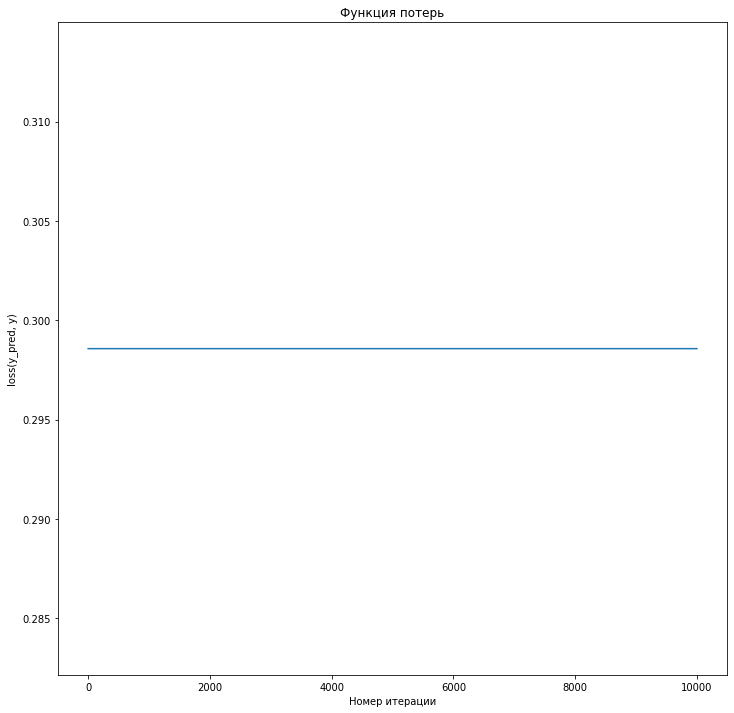

In [18]:
plot_loss_function(loss_values_relu_ap_zero)

Скорее всего сейчас у вас лосс -- это прямая линия, и вы видите, что веса не обновляются. Но почему?

Всё просто -- если присмотреться, то видно, что self.w и self.b иницилизируются нулями в начале `.fit()`-метода. Если расписать, как будет идти обновление, то видно, что из-за ReLU веса просто-напросто не будут обновляться, если начать с инициализации нулями. 

Это -- одна из причин, по которой в нейронных сетях веса инициализируют случаными числами (обычно из отрезка [0, 1)).

Обучите нейрон, инициализировав случайно веса (поставьте 10000 итераций). 

Закомментируйте инициализацию нулями в функции `.fit()` класса `NeuronReLU` 

##### Построение модели

In [52]:
%%time
model_relu_ap = Neuron(learning_rate=0.01,
                       activation_function=relu,
                       activation_function_derivative=relu_derivative,
                       epoch_number=10000,
                       w=np.random.rand(x_train_relu_ap.shape[1], 1), 
                       b=float(np.random.rand(1)))

loss_values_relu_ap = model_relu_ap.fit(x_train_relu_ap, y_train_relu_ap)

CPU times: user 887 ms, sys: 4.95 ms, total: 892 ms
Wall time: 901 ms


##### Построение графика функции потерь

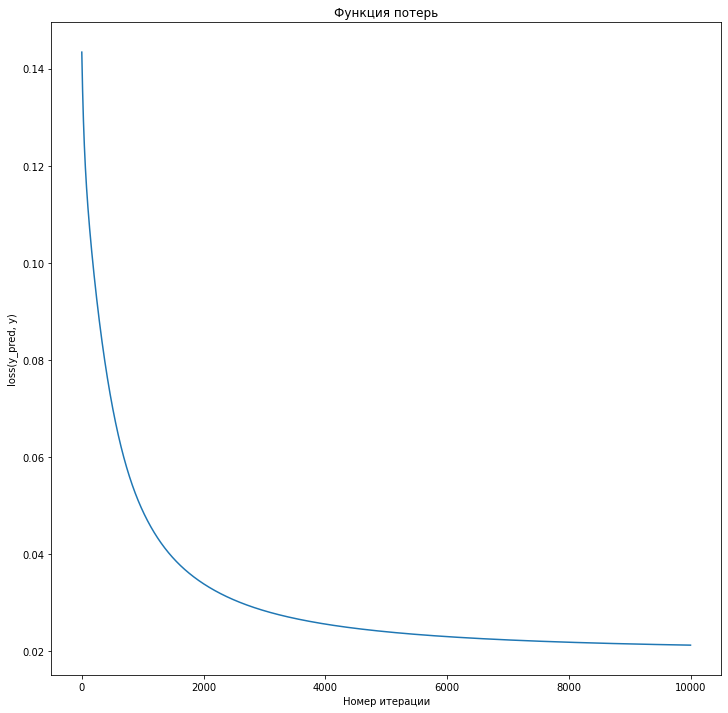

In [53]:
plot_loss_function(loss_values_relu_ap)

##### Оценка наилучшего порогового значения для классификации

In [54]:
best_accuracy_relu_ap, best_f1_relu_ap = print_best_threshold(model_relu_ap, 
                                                              x_test_relu_ap, 
                                                              y_test_relu_ap, 
                                                              np.arange(0.001, 1.001, 0.001))   

Best threshold for accuracy: 0.661 with accuracy = 0.9966666666666667
Best threshold for f1: 0.661 with f1 = 0.9970674486803519


##### Построение графика распределения с полученным наилучшим порогом

###### Accuracy

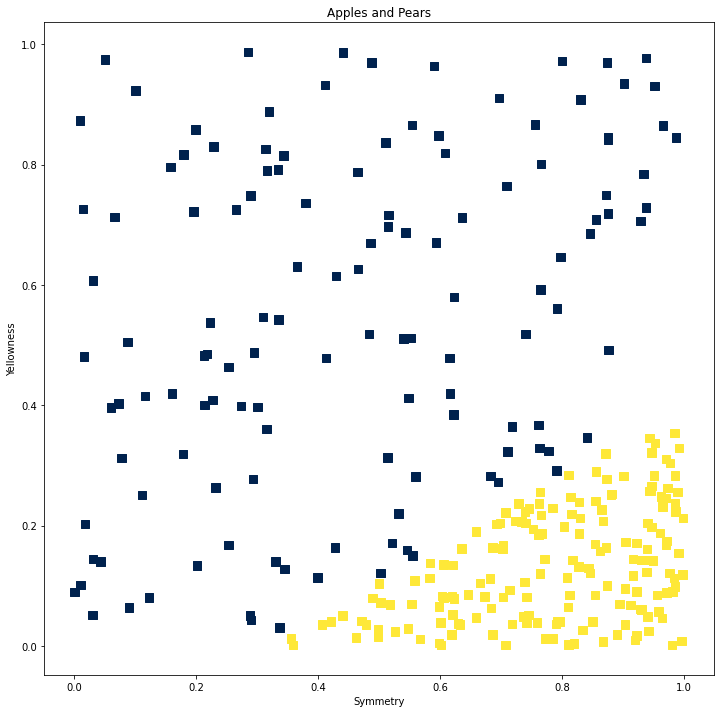

In [55]:
plot_ap(x_test_relu_ap, model_relu_ap.predict(x_test_relu_ap, best_accuracy_relu_ap[0]))

###### F1 Score

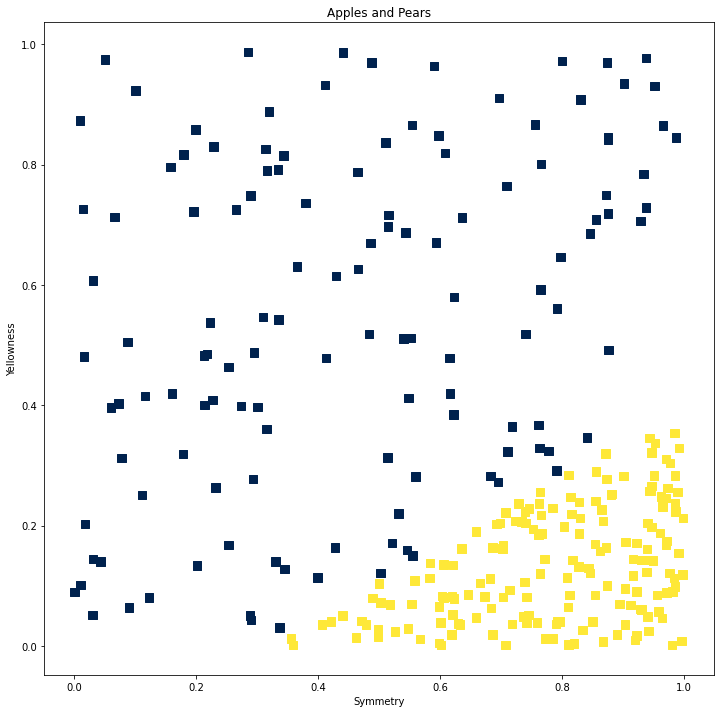

In [56]:
plot_ap(x_test_relu_ap, model_relu_ap.predict(x_test_relu_ap, best_f1_relu_ap[0]))

#### Набор "Голос"

##### Построение модели

In [24]:
voice_relu_v = voice.copy(deep=True)
x_train_relu_v, x_test_relu_v, y_train_relu_v, y_test_relu_v = train_test_split(
    voice_relu_v.drop('label', axis=1),
    voice_relu_v['label'],
    test_size=0.3)

x_train_relu_v = x_train_relu_v.values
y_train_relu_v = y_train_relu_v.values.reshape(-1, 1)
x_test_relu_v = x_test_relu_v.values
y_test_relu_v = y_test_relu_v.values.reshape(-1, 1)

In [25]:
%%time
model_relu_v = Neuron(learning_rate=0.01,
                        activation_function=relu,
                        activation_function_derivative=relu_derivative,
                        epoch_number=10000,
                        w=np.random.rand(x_train_relu_v.shape[1], 1),
                        b=float(np.random.rand(1)))

loss_values_relu_v = model_relu_v.fit(x_train_relu_v, y_train_relu_v)

CPU times: user 4.27 s, sys: 3.64 s, total: 7.91 s
Wall time: 4.15 s


##### Построение графика функции потерь

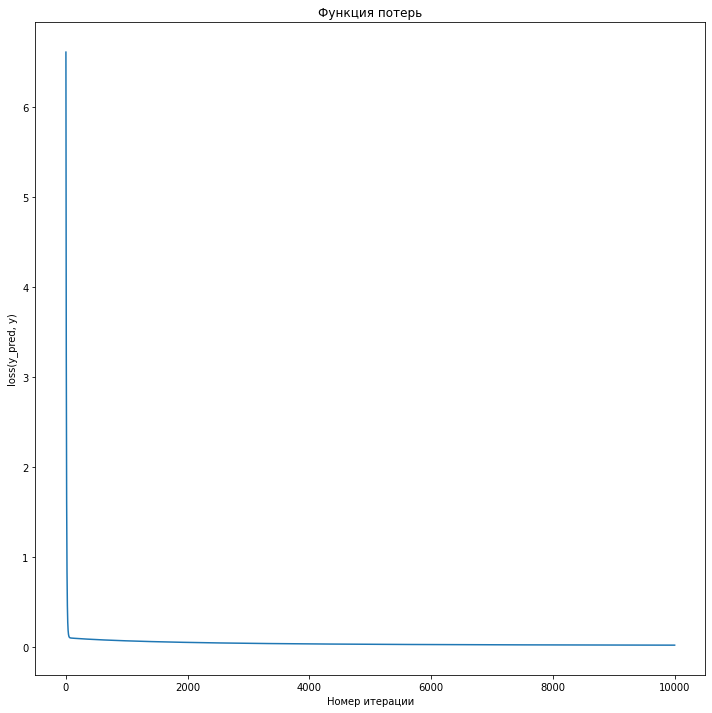

In [26]:
plot_loss_function(loss_values_relu_v)

##### Оценка наилучшего порогового значения для классификации

In [27]:
best_accuracy_relu_v, best_f1_relu_v = print_best_threshold(model_relu_v, 
                                                              x_test_relu_v, 
                                                              y_test_relu_v, 
                                                              np.arange(0.001, 1.001, 0.001))  

Best threshold for accuracy: 0.516 with accuracy = 0.9684542586750788
Best threshold for f1: 0.516 with f1 = 0.9703557312252964


Есть одна тенденция: пороговая функция активации и сигмоида (обычно всё же только сигмоида) чаще используются именно на **выходном слое** нейросети в задаче классификации -- ими предсказывают вероятности объектов принадлежать одному из классов, в то время как продвинутые функции активации (ReLU и те, что будут дальше) используются внутри нейросети, то есть в **скрытых слоях**.

Нужно понимать, что ReLU не может вернуть отрицательные числа.

**Плюсы ReLU:**

* дифференцируемая (с доопределе
нием в нуле)
* нет проблемы затухающих градиентов, как в сигмоиде

**Возможные минусы ReLU:**

* не центрирована около 0 (может мешать скорости сходимсти)
* зануляет все отрицательные входы, тем самым веса у занулённых нейронов могут часто *не обновляться*, эту проблему иногда называют *мёртвые нейроны*

С последней проблемой можно побороться, а именно:

## Нейрон с LeakyReLU (Leaky Recitified Linear Unit) 

LeakyReLU очень слабо отличается от ReLU, но часто помогает сети обучаться быстрее, поскольку нет проблемы "мёртвых нейронов":

\begin{equation*}
LeakyReLU(x) =
 \begin{cases}
   \alpha x, &\text{$x \le 0$}\\
   x, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

где $\alpha$ -- маленькое число от 0 до 1.

Производная здесь берётся так же, но вместо нуля будет $\alpha$:

\begin{equation*}
LeakyReLU'(x) = 
 \begin{cases}
   \alpha, &\text{$x \le 0$}\\
   1, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

График этой функции:

<img src="https://cdn-images-1.medium.com/max/1600/0*UtLlZJ80TMIM7kXk." width=400 height=300>

Подставим LeakyReLu в Loss:

$$
Loss(\hat{y}, y) = \frac{1}{2n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{2n}\sum_{i=1}^{n} (LeakyReLU(w \cdot X_i) - y_i)^2 =
\begin{equation*}
\frac{1}{2n}\sum_{i=1}^{n} 
 \begin{cases}
   (\alpha \cdot w \cdot X_i - y_i)^2, &{w \cdot X_i \le 0}\\
   (w \cdot X_i - y_i)^2, &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}
$$  

Формула для обновления весов при градиентном спуске:

$$ \frac{\partial Loss}{\partial w} = \begin{equation*}
\frac{1}{n}\sum_{i=1}^{n} 
 \begin{cases}
   \alpha X_i^T (w \cdot X_i - y), &{w \cdot X_i \le 0}\\
    X_i^T (w \cdot X_i - y), &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$

* Реализуйте LeakyReLU и её производную:

In [28]:
def leaky_relu(x, alpha=0.01):
    """LeakyReLU-функция"""
    return np.maximum(0, x) + alpha * np.minimum(0, x)

In [29]:
def leaky_relu_derivative(x, alpha=0.01):
    """Производная LeakyReLU"""
    return (x > 0).astype(int) + alpha * (x < 0).astype(int)

### Тестирование нейрона с LeakyReLU

#### Набор "Яблоки и Груши"

##### Построение модели

In [30]:
apples_pears_leaky_relu = apples_pears.copy(deep=True)
x_train_leaky_relu_ap, x_test_leaky_relu_ap, y_train_leaky_relu_ap, y_test_leaky_relu_ap = train_test_split(
    apples_pears_leaky_relu.drop('target', axis=1),
    apples_pears_leaky_relu['target'],
    test_size=0.3)

x_train_leaky_relu_ap = x_train_leaky_relu_ap.values
y_train_leaky_relu_ap = y_train_leaky_relu_ap.values.reshape(-1, 1)
x_test_leaky_relu_ap = x_test_leaky_relu_ap.values
y_test_leaky_relu_ap = y_test_leaky_relu_ap.values.reshape(-1, 1)

In [71]:
%%time
model_leaky_relu_ap = Neuron(learning_rate=0.01,
                       activation_function=leaky_relu,
                       activation_function_derivative=leaky_relu_derivative,
                       epoch_number=10000,
                       w=np.random.rand(x_train_leaky_relu_ap.shape[1], 1), 
                       b=float(np.random.rand(1)))

loss_values_leaky_relu_ap = model_leaky_relu_ap.fit(x_train_leaky_relu_ap, y_train_leaky_relu_ap)

CPU times: user 1.05 s, sys: 3.7 ms, total: 1.05 s
Wall time: 1.06 s


##### Построение графика функции потерь

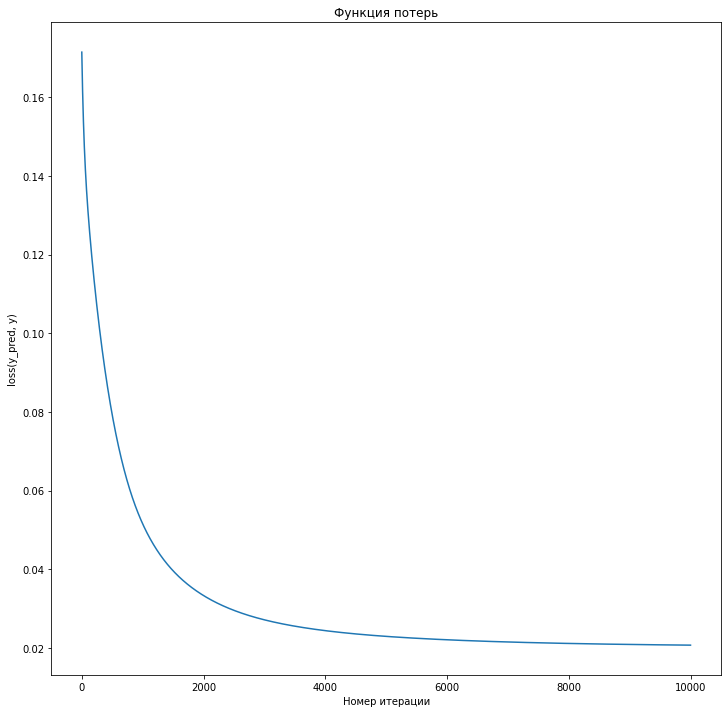

In [72]:
plot_loss_function(loss_values_leaky_relu_ap)

##### Оценка наилучшего порогового значения для классификации

In [73]:
best_accuracy_leaky_relu_ap, best_f1_leaky_relu_ap = print_best_threshold(model_leaky_relu_ap, 
                                                                          x_test_leaky_relu_ap, 
                                                                          y_test_leaky_relu_ap, 
                                                                          np.arange(0.001, 1.001, 0.001))   

Best threshold for accuracy: 0.64 with accuracy = 0.9866666666666667
Best threshold for f1: 0.64 with f1 = 0.9881656804733728


##### Построение графика распределения с полученным наилучшим порогом

###### Accuracy

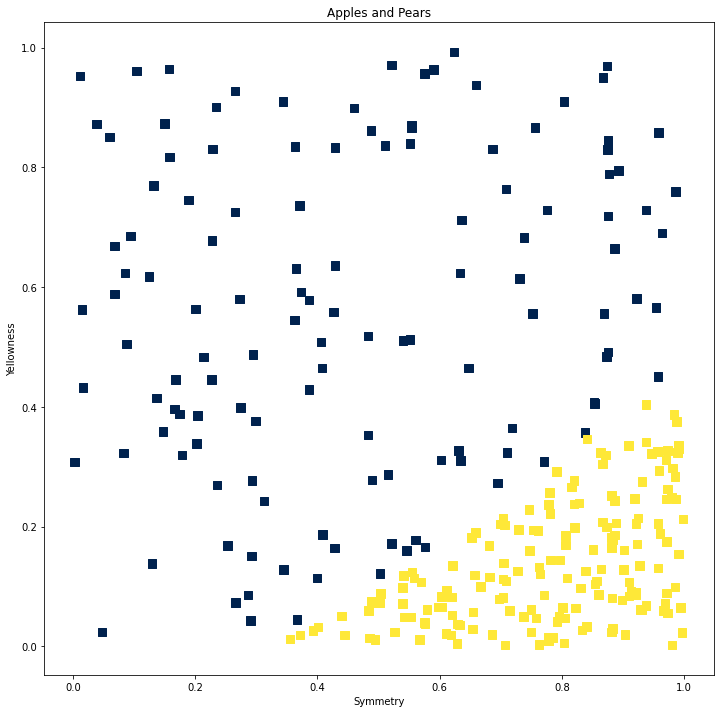

In [74]:
plot_ap(x_test_leaky_relu_ap, model_leaky_relu_ap.predict(x_test_leaky_relu_ap, best_accuracy_leaky_relu_ap[0]))

###### F1 Score

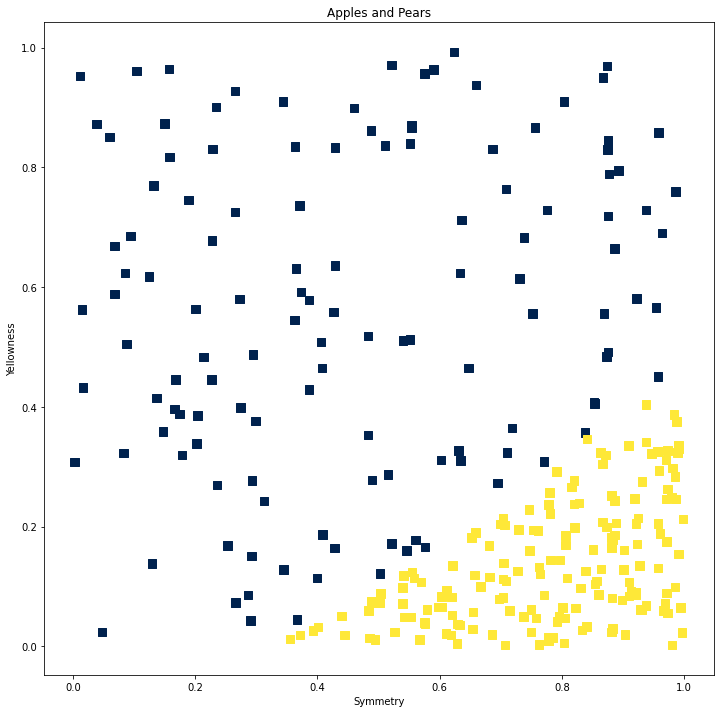

In [75]:
plot_ap(x_test_leaky_relu_ap, model_leaky_relu_ap.predict(x_test_leaky_relu_ap, best_f1_leaky_relu_ap[0]))

#### Набор "Голос"

##### Построение модели

In [36]:
voice_leaky_relu_v = voice.copy(deep=True)
x_train_leaky_relu_v, x_test_leaky_relu_v, y_train_leaky_relu_v, y_test_leaky_relu_v = train_test_split(
    voice_leaky_relu_v.drop('label', axis=1),
    voice_leaky_relu_v['label'],
    test_size=0.3)

x_train_leaky_relu_v = x_train_leaky_relu_v.values
y_train_leaky_relu_v = y_train_leaky_relu_v.values.reshape(-1, 1)
x_test_leaky_relu_v = x_test_leaky_relu_v.values
y_test_leaky_relu_v = y_test_leaky_relu_v.values.reshape(-1, 1)

In [37]:
%%time
model_leaky_relu_v = Neuron(learning_rate=0.01,
                            activation_function=leaky_relu,
                            activation_function_derivative=leaky_relu_derivative,
                            epoch_number=10000,
                            w=np.random.rand(x_train_leaky_relu_v.shape[1], 1),
                            b=float(np.random.rand(1)))

loss_values_leaky_relu_v = model_leaky_relu_v.fit(x_train_leaky_relu_v, y_train_leaky_relu_v)

CPU times: user 4.36 s, sys: 3.67 s, total: 8.03 s
Wall time: 4.21 s


##### Построение графика функции потерь

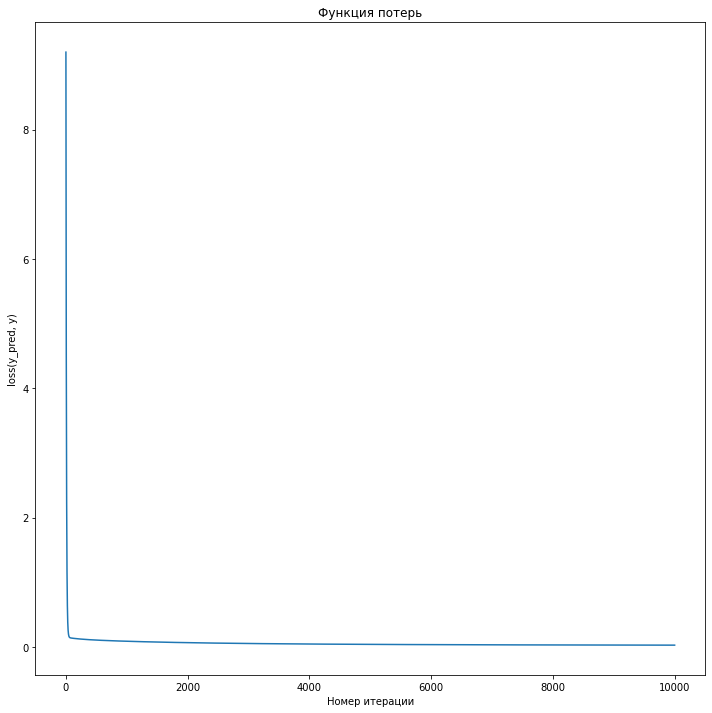

In [38]:
plot_loss_function(loss_values_leaky_relu_v)

##### Оценка наилучшего порогового значения для классификации

In [39]:
best_accuracy_leaky_relu_v, best_f1_leaky_relu_v = print_best_threshold(model_leaky_relu_v, 
                                                                        x_test_leaky_relu_v, 
                                                                        y_test_leaky_relu_v, 
                                                                        np.arange(0.001, 1.001, 0.001)) 

Best threshold for accuracy: 0.5710000000000001 with accuracy = 0.964248159831756
Best threshold for f1: 0.5710000000000001 with f1 = 0.9644351464435146


**Плюсы LeakyReLU:**

* дифференцируемая (с доопределнием в нуле)
* нет проблемы затухающих градиентов, как в сигмоиде
* нет проблемы "мёртвых нейронов", как в ReLU

**Возможные минусы LeakyReLU:**

* не центрирована около 0 (может мешать скорости сходимсти)
* немного не устойчива к "шуму" (см. лекции Стэнфорда)

## Нейрон с ELU (Exponential Linear Unit)

ELU -- не так давно предложенная (в 2015 году) функция активации, которая, как говорят авторы статьи, лучше LeakyReLU. Вот формула ELU:

\begin{equation*}
ELU(\alpha, x) =
 \begin{cases}
   \alpha (e^x - 1), &\text{$x \le 0$}\\
   x, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

где $\alpha$ -- маленькое число от 0 до 1.

Производная здесь берётся так же, но вместо нуля будет $\alpha$:

\begin{equation*}
ELU'(x) = 
 \begin{cases}
   ELU(\alpha, x) + \alpha, &\text{$x \le 0$}\\
   1, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

Здесь в производной использован постой трюк -- сделано $- \alpha + \alpha$, чтобы вычислять было проще.

График этой функции:

<img src="http://p0.ifengimg.com/pmop/2017/0907/A004001DD141881BFD8AD62E5D31028C3BE3FAD1_size14_w446_h354.png" width=500 height=400>

Подставим LeakyReLu в Loss:

$$Loss(\hat{y}, y) = \frac{1}{2n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{2n}\sum_{i=1}^{n} (ELU(\alpha, w \cdot X_i) - y_i)^2 = \begin{equation*}
\frac{1}{2n}\sum_{i=1}^{n} 
 \begin{cases}
   (\alpha (e^{w \cdot X_i} - 1) - y_i)^2, &{w \cdot X_i \le 0}\\
   (w \cdot X_i - y_i)^2, &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$  

Здесь вам нужно выписать самим град спуск для весов. Брать производную "в лоб" некрасиво и неудобно. Нужно воспользоваться **правилом цепочки**, оно же **правило взятия производной сложной функции**:

$$ \frac{\partial Loss}{\partial w} = \begin{equation*}
\frac{1}{n}\sum_{i=1}^{n} 
 \begin{cases}
   , &{w \cdot X_i \le 0}\\
   , &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$

* Реализуйте ELU и её производную:

In [40]:
def elu(x: np.array, alpha: float) -> np.array:
    """ELU-функция"""
    return np.where(x > 0, x, alpha * (np.exp(x) - 1))

In [41]:
def elu_derivative(x: np.array, alpha: float) -> np.array:
    """Производная ELU"""
    return np.where(x > 0, 1, alpha * np.exp(x))

### Тестирование нейрона с ELU

#### Набор "Яблоки и Груши"

##### Построение модели

In [42]:
apples_pears_elu = apples_pears.copy(deep=True)
x_train_elu_ap, x_test_elu_ap, y_train_elu_ap, y_test_elu_ap = train_test_split(
    apples_pears_elu.drop('target', axis=1),
    apples_pears_elu['target'],
    test_size=0.3)

x_train_elu_ap = x_train_elu_ap.values
y_train_elu_ap = y_train_elu_ap.values.reshape(-1, 1)
x_test_elu_ap = x_test_elu_ap.values
y_test_elu_ap = y_test_elu_ap.values.reshape(-1, 1)

In [64]:
%%time
model_elu_ap = Neuron(learning_rate=0.01,
                       activation_function=elu,
                       activation_function_derivative=elu_derivative,
                       epoch_number=10000,
                       w=np.random.rand(x_train_elu_ap.shape[1], 1), 
                       b=float(np.random.rand(1)))

loss_values_elu_ap = model_elu_ap.fit(x_train_elu_ap, y_train_elu_ap)

CPU times: user 1.43 s, sys: 4.2 ms, total: 1.44 s
Wall time: 1.44 s


##### Построение графика функции потерь

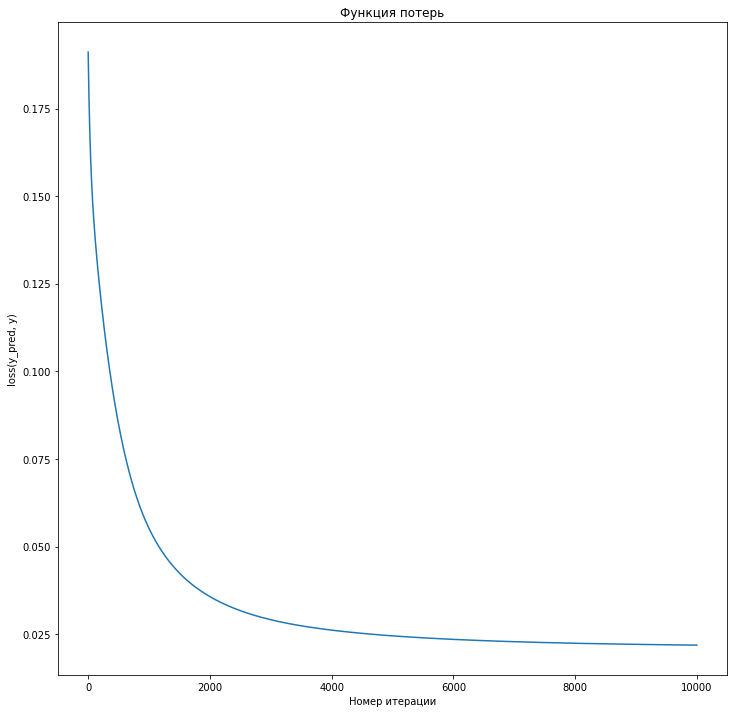

In [65]:
plot_loss_function(loss_values_elu_ap)

##### Оценка наилучшего порогового значения для классификации

In [66]:
best_accuracy_elu_ap, best_f1_elu_ap = print_best_threshold(model_elu_ap, 
                                                            x_test_elu_ap, 
                                                            y_test_elu_ap, 
                                                            np.arange(0.001, 1.001, 0.001))  

Best threshold for accuracy: 0.669 with accuracy = 0.9966666666666667
Best threshold for f1: 0.669 with f1 = 0.9971181556195965


##### Построение графика распределения с полученным наилучшим порогом

###### Accuracy

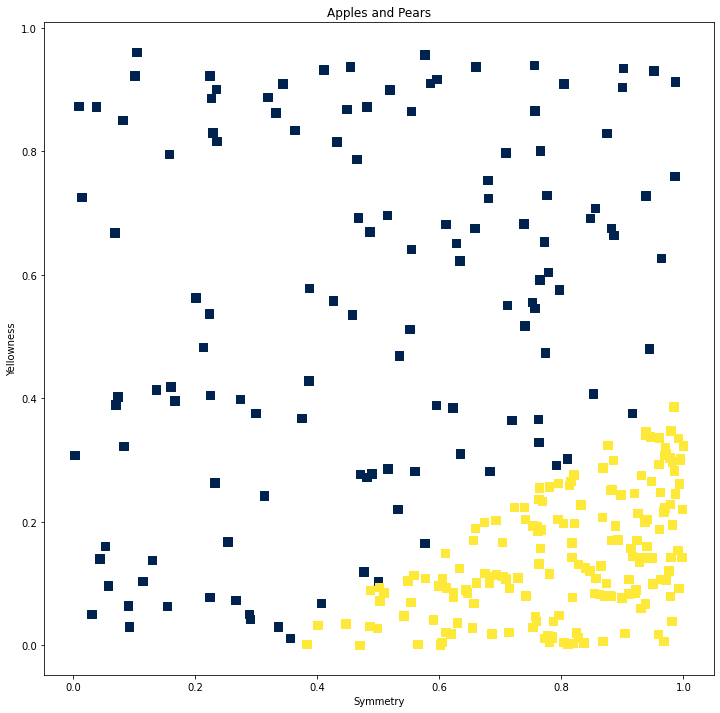

In [67]:
plot_ap(x_test_elu_ap, model_elu_ap.predict(x_test_elu_ap, best_accuracy_elu_ap[0]))

###### F1 Score

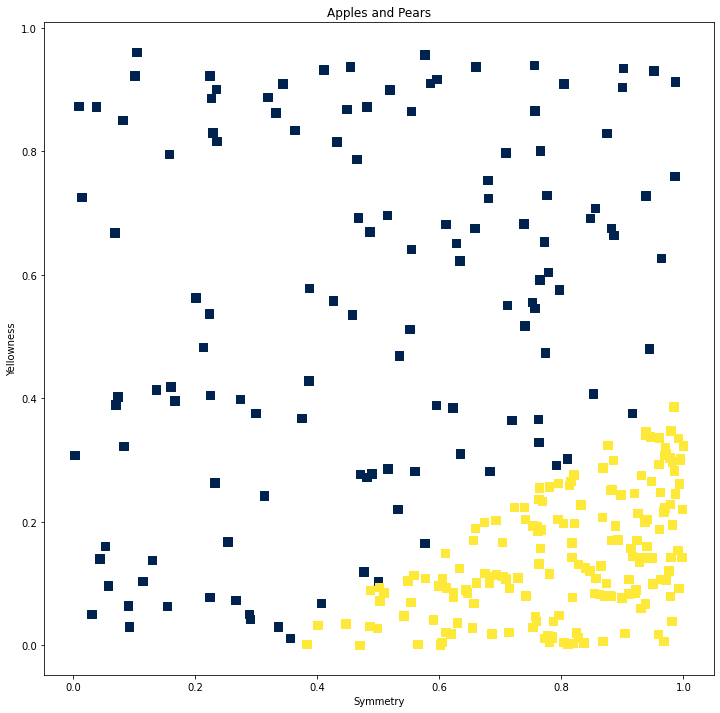

In [68]:
plot_ap(x_test_elu_ap, model_elu_ap.predict(x_test_elu_ap, best_f1_elu_ap[0]))

#### Набор "Голос"

##### Построение модели

In [48]:
voice_elu_v = voice.copy(deep=True)
x_train_elu_v, x_test_elu_v, y_train_elu_v, y_test_elu_v = train_test_split(
    voice_elu_v.drop('label', axis=1),
    voice_elu_v['label'],
    test_size=0.3)

x_train_elu_v = x_train_elu_v.values
y_train_elu_v = y_train_elu_v.values.reshape(-1, 1)
x_test_elu_v = x_test_elu_v.values
y_test_elu_v = y_test_elu_v.values.reshape(-1, 1)

In [49]:
%%time
model_elu_v = Neuron(learning_rate=0.01,
                            activation_function=elu,
                            activation_function_derivative=elu_derivative,
                            epoch_number=10000,
                            w=np.random.rand(x_train_elu_v.shape[1], 1),
                            b=float(np.random.rand(1)))

loss_values_elu_v = model_elu_v.fit(x_train_elu_v, y_train_elu_v)

CPU times: user 6.35 s, sys: 5.44 s, total: 11.8 s
Wall time: 6.21 s


##### Построение графика функции потерь

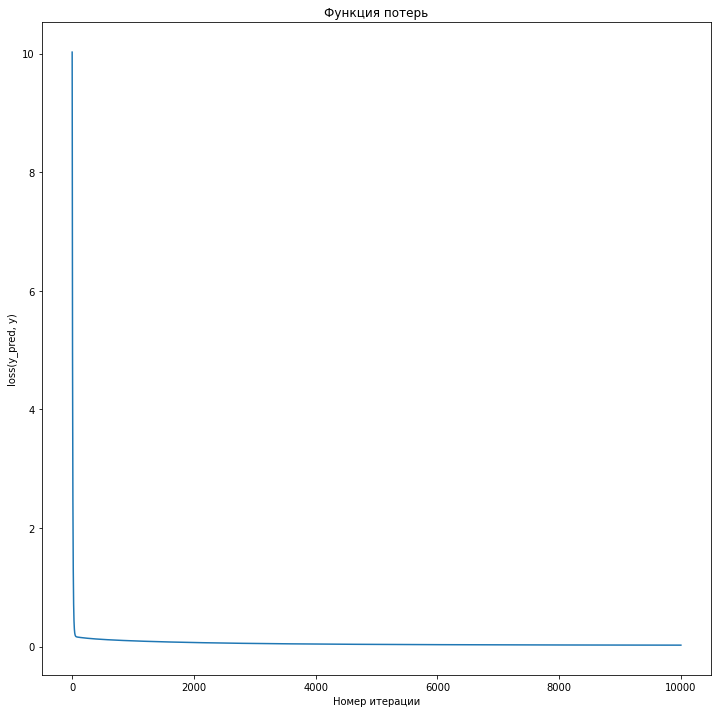

In [50]:
plot_loss_function(loss_values_elu_v)

##### Оценка наилучшего порогового значения для классификации

In [51]:
best_accuracy_elu_v, best_f1_elu_v = print_best_threshold(model_elu_v, 
                                                          x_test_elu_v, 
                                                          y_test_elu_v, 
                                                          np.arange(0.001, 1.001, 0.001))  

Best threshold for accuracy: 0.5660000000000001 with accuracy = 0.9631966351209253
Best threshold for f1: 0.5660000000000001 with f1 = 0.9623250807319699


**Плюсы ELU:**

* дифференцируемая (с доопределнием в нуле)
* нет проблемы затухающих градиентов, как в сигмоиде
* нет проблемы "мёртвых нейронов", как в ReLU
* более устойчива к "шуму" (см. лекции Стэнфорда)

**Возможные минусы ELU:**

* не очень хорошо центрирована около 0 (может мешать скорости сходимсти)
* вычислительно дольше, чем ReLU и LeakyReLU